In [1]:
import os
import threading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from osgeo import gdal


In [3]:
print(os.getcwd()) 

os.chdir('E:\热浪\data\WBGT\Temp')


E:\热浪\data\WBGT\Temp


In [4]:
import re
import os
import glob
import pandas as pd


# 为csv文件添加省份字段


# for file in glob.glob('./Daily*.csv'):
#     (
#         pd
#         .read_csv(file)
#         .assign(name=re.findall('Daily-(.*?)-', file)[0])
#         .to_csv('处理后_'+os.path.split(file)[-1])
#           )


In [5]:
# 合并csv文件

# extension = 'csv'
# all_filenames = [i for i in glob.glob('处理后_Daily-*.{}'.format(extension))]
# #combine all files in the list
# combined_csv = pd.concat([pd.read_csv(f,low_memory=False) for f in all_filenames ])
# #export to csv
# combined_csv.to_csv( "Temp-Daily-1980-2019.csv", index=False)

In [4]:
# 打开 1980-1999每日数据 计算历史时期的温度阈值
demo = pd.read_csv('Temp-Daily-1980-2019.csv', parse_dates=['system:time_start']).iloc[:, 1:]
demo.head(3)


,system:time_start,C,name
0,1980-05-01,27.371,Anhui
1,1980-05-02,26.961,Anhui
2,1980-05-03,29.581,Anhui


In [5]:
from sklearn.cluster import DBSCAN

In [88]:
def extract_info(group_name, group_df):
    
    # 初始化DBSCAN模型
    model = DBSCAN(eps=1.1, min_samples=1, n_jobs=-2)
    
    group_df = (
        group_df
        # 计算聚类用量化日期
        .assign(
            day_num=(group_df['system:time_start'] - group_df['system:time_start'].min()).dt.days
        )
        # 保留超出阈值的记录
        .query('C > 40')
        .assign(
            # 利用DBSCAN快速计算得到日期连续的记录片段
            cluster_label=lambda df: model.fit_predict(df['day_num'].values.reshape(-1, 1))
        )
        .groupby('cluster_label')
        .filter(lambda df: df.shape[0] >= 1)
        # 按年度统计各项指标
        .assign(year=lambda df: df['system:time_start'].dt.year)
        .groupby('year')
        .agg(
            发生频次=pd.NamedAgg(column='cluster_label', aggfunc='nunique'),
            总和持续天数=pd.NamedAgg(column='cluster_label', aggfunc='size'),
            平均持续天数=pd.NamedAgg(column='cluster_label', aggfunc=lambda s: s.size / s.nunique() if s.nunique() else 0)
        )
        .assign(地区=group_name)
        .join(
            # 补充不同计算逻辑下的高温均值指标
            group_df
            .assign(year=lambda df: df['system:time_start'].dt.year)
            # 保留超出阈值的记录
            .query('C > 40')
            .groupby('year')
            .agg(高温均值=pd.NamedAgg(column='C', aggfunc='mean'))
        )
        .reset_index(drop=False)
    )
    
    return group_df

In [89]:
result = (
    pd
    .concat(
        [
            extract_info(*group)
            for group in demo.groupby('name')
            if not group[1].query('C > 40').empty
        ],
        ignore_index=True
    )
)
# result.to_csv(r'分省分年高温红色预警.csv')
result

,year,发生频次,总和持续天数,平均持续天数,地区,高温均值
0,1992,1,1,1.000000,Anhui,40.065000
1,1994,3,3,1.000000,Anhui,40.468000
2,1999,1,1,1.000000,Anhui,40.652000
3,2001,2,2,1.000000,Anhui,40.266000
4,2002,1,1,1.000000,Anhui,41.167000
...,...,...,...,...,...,...
491,2013,6,25,4.166667,Zhejiang,41.679840
492,2015,1,3,3.000000,Zhejiang,40.307333
493,2016,2,3,1.500000,Zhejiang,40.557667
494,2017,3,11,3.666667,Zhejiang,41.054909


In [91]:
# year_sum = result.groupby('year')['发生频次'].sum()

# year_sum.to_csv('每年红色预警次数.csv')

# os.getcwd()

'E:\\热浪\\figure'

In [8]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 

def lm_func(df, col):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df["year"]).reshape((-1, 1))
    Y_stats = np.array(df[col]).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1])
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

In [5]:
data1 = pd.read_csv('E:\\热浪\\data\\WBGT\\Temp\\每年预警次数.csv',encoding = 'GBK')
data1 = pd.DataFrame(data1)

# data = data['events']
data1.head()

,year,Yellow warning,Orange warning,Red warning
0,1980,96,121,28
1,1981,116,141,30
2,1982,103,106,20
3,1983,110,130,20
4,1984,87,94,17


In [6]:
data2 = pd.read_csv('E:\\热浪\\data\\WBGT\\04 每年的热浪次数和天数.csv',encoding = 'GBK')
data2 = pd.DataFrame(data2)

# data = data['events']
data2.head()


,Year,Events (times),Duration (days),Avarage WBGTmax (℃) over threshold,Cumulative WBGTmax (℃) over threshold,Avarage intensity (℃),Cumulative intensity (℃),Frequency (times)
0,1980,59,273,0.91,7.52,0.91,7.52,59
1,1981,90,523,1.22,20.80,1.22,20.80,90
2,1982,35,175,0.74,9.97,0.74,9.97,35
3,1983,61,340,0.94,9.51,0.94,9.51,61
4,1984,51,232,0.91,8.22,0.91,8.22,51


In [7]:
import matplotlib
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

import statsmodels.api as sm
import seaborn as sns
from matplotlib import rcParams

os.chdir('E:\\热浪\\figure')



In [8]:
from scipy import stats
import numpy as np
from sklearn.linear_model import LinearRegression

data = pd.merge(data1,data2,left_on='year',right_on='Year')
data.head()



,year,Yellow warning,Orange warning,Red warning,Year,Events (times),Duration (days),Avarage WBGTmax (℃) over threshold,Cumulative WBGTmax (℃) over threshold,Avarage intensity (℃),Cumulative intensity (℃),Frequency (times)
0,1980,96,121,28,1980,59,273,0.91,7.52,0.91,7.52,59
1,1981,116,141,30,1981,90,523,1.22,20.80,1.22,20.80,90
2,1982,103,106,20,1982,35,175,0.74,9.97,0.74,9.97,35
3,1983,110,130,20,1983,61,340,0.94,9.51,0.94,9.51,61
4,1984,87,94,17,1984,51,232,0.91,8.22,0.91,8.22,51


In [9]:
# 黄色预警

target = data["Yellow warning"]
prediction =data["Frequency (times)"]

rho, pval = stats.pearsonr(prediction , target)
R2_Yellow = rho*rho
print(R2_Yellow,pval)

0.46503196471179487 1.2645705435162792e-06


In [10]:
# 橙色预警

target = data["Orange warning"]
prediction =data["Frequency (times)"]

rho, pval = stats.pearsonr(prediction , target)
R2_Orange = rho*rho
print(R2_Orange,pval)

0.47768752953025545 7.927028713523364e-07


In [51]:
# 红色预警

target = data["Red warning"]
prediction =data["Frequency (times)"]

rho, pval = stats.pearsonr(prediction , target)
R2_Red = rho*rho
print(R2_Red,pval)

0.47466116488714705 8.872269152554521e-07


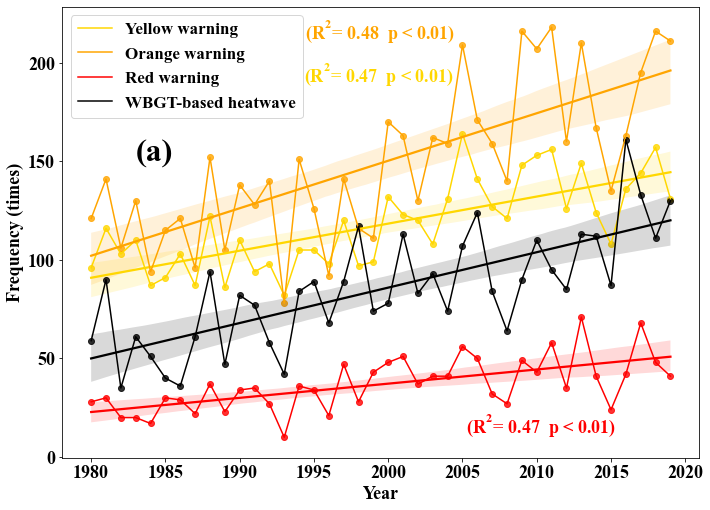

In [61]:
fig, ax = plt.subplots(figsize=(10,7))
matplotlib.rcParams['font.size'] = 18.0
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.subplots_adjust(left=0.09, right=0.975, top=0.995, bottom=0.1)


g = sns.lineplot(data=data, x="year",y="Yellow warning",color="gold",label='Yellow warning')
g = sns.regplot(data=data, x="Year",y="Yellow warning",color="gold")

g = sns.lineplot(data=data, x="year",y="Orange warning",color="orange",label='Orange warning')
g = sns.regplot(data=data, x="year",y="Orange warning",color="orange")

g = sns.lineplot(data=data, x="year",y="Red warning",color="red",label='Red warning')
g = sns.regplot(data=data, x="year",y="Red warning",color="red")

g = sns.lineplot(x="Year",y="Frequency (times)",data=data,color="black",label='WBGT-based heatwave')
g = sns.regplot(data=data, x="Year",y="Frequency (times)",color="black")

text_Yellow = '($\mathregular{R^2}$= '+  str(round(R2_Yellow, 2))+'  p < 0.01) '
text_Orange = ' ($\mathregular{R^2}$= '+  str(round(R2_Orange, 2))+'  p < 0.01) '
text_Red = ' ($\mathregular{R^2}$= '+  str(round(R2_Red, 2))+'  p < 0.01) '


plt.text(x=1994.3,y=190, s= text_Yellow, size=18, color = 'gold')
plt.text(x=1994.1,y=212, s= text_Orange, size=18, color = 'orange')
plt.text(x=2005,y=12, s= text_Red, size=18, color = 'red')

plt.legend( bbox_to_anchor=(0.39, 0.75), loc=0, borderaxespad=-0.1)
# plt.legend(loc=4)
# plt.legend(frameon=False)
legend_font = {
    'family': 'Times New Roman',  # 字体
    'style': 'normal',
    'size': 17,  # 字号
    'weight': "bold",  # 是否加粗，不加粗
    }

    #ax.legend(labels = 'band',loc='best')
# ax.legend(loc='upper right',frameon=False,prop=legend_font)
ax.legend(loc='upper left',prop=legend_font)


plt.text(x=1983,y=150 , s= "(a)", size=32, color = 'black',fontweight='bold')

plt.savefig('10-a-热浪对比.jpg', dpi=300)
plt.show()

In [33]:
data = pd.merge(data1,data2,left_on='year',right_on='Year')
data.head()

,发生频次,Year,Events (times),Duration (days),Avarage WBGTmax (℃) over threshold,Cumulative WBGTmax (℃) over threshold,Avarage intensity (℃),Cumulative intensity (℃),Frequency (times)
0,96,1980,59,273,0.91,7.52,0.91,7.52,59
1,116,1981,90,523,1.22,20.80,1.22,20.80,90
2,103,1982,35,175,0.74,9.97,0.74,9.97,35
3,110,1983,61,340,0.94,9.51,0.94,9.51,61
4,87,1984,51,232,0.91,8.22,0.91,8.22,51


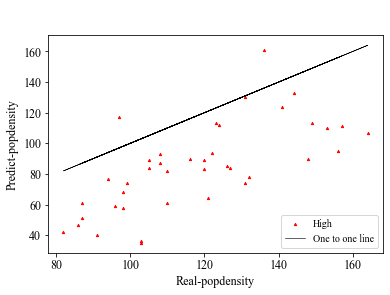

In [43]:
x =  data["Year"]

target = data["发生频次"]
prediction =data["Frequency (times)"]


plt.scatter(target, prediction, c='red', marker='^',s= 5, label='High')


plt.plot(target, target,color='black',linewidth=0.6,label='One to one line')
# plt.plot(x, yvals1,color='magenta',linewidth=1,linestyle = ':',
#           label='Fitting line')

plt.title('\n')
plt.ylabel('Predict-popdensity', fontsize=12)
plt.xlabel('Real-popdensity', fontsize=12)
# plt.xticks(np.arange(1980,2019, step=1))
# plt.xticks(np.arange(4), ('1980', '1990', '2000', '2010'))
# plt.yticks(np.arange(5), ('1', '100', '1000', '10000', '100000'))

plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.legend(loc=4)
# plt.grid()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('test.jpg',dpi=400)
plt.show()